In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULT_DIR = '../../results/'
PREFIX_DIR = os.path.join(RESULT_DIR, 'prefix-alignment')
HMMCONF_DIR = os.path.join(RESULT_DIR, 'hmmconf', 'avg')
PATT_DIR = os.path.join(RESULT_DIR, 'pattern')

In [3]:
prefix_df_list = []

for fname in os.listdir(PREFIX_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PREFIX_DIR, fname)
    df = pd.read_csv(fp)
    df['log'] = fname.replace('.csv', '')
    prefix_df_list.append(df)
    
prefix_df = pd.concat(prefix_df_list)

hmm_df_list = []

for fname in os.listdir(HMMCONF_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(HMMCONF_DIR, fname)
    df = pd.read_csv(fp, header=[0, 1])
    df = df.drop(columns=['std', 'count'], level=1)
    df.columns = df.columns.droplevel(level=1)
    df['log'] = fname.replace('.csv', '')
    hmm_df_list.append(df)

hmm_df = pd.concat(hmm_df_list)

patt_df_list = []

for fname in os.listdir(PATT_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PATT_DIR, fname)
    df = pd.read_csv(fp, sep='\t')
    df['log'] = fname.replace('.csv', '')
    patt_df_list.append(df)

patt_df = pd.concat(patt_df_list)
patt_df.rename(columns={
    'T:concept:name': 'caseid',
    'E:concept:name': 'activity'
}, inplace=True)

# create case_length
patt_df['tmp'] = 1
patt_df['case_length'] = patt_df[['caseid', 'log', 'tmp']].groupby(['log', 'caseid']).cumsum()
patt_df.drop(columns=['tmp'], inplace=True)

merged_df = pd.merge(prefix_df, patt_df, on=['log', 'caseid', 'case_length'])
merged_df = pd.merge(merged_df, hmm_df, on=['log', 'caseid', 'case_length'])

assert (merged_df['activity_x'] == merged_df['activity_y']).all()

merged_df.rename(columns={'activity_x': 'activity'}, inplace=True)
merged_df.drop(columns=['activity_y'], inplace=True)

In [4]:
sort_order = ['log', 'caseid', 'case_length']
prefix_df = prefix_df.sort_values(sort_order)
hmm_df = hmm_df.sort_values(sort_order)
patt_df = patt_df.sort_values(sort_order)

assert prefix_df[sort_order].equals(hmm_df[sort_order])
assert patt_df[sort_order].equals(hmm_df[sort_order])

In [5]:
del hmm_df_list
del prefix_df_list
del patt_df_list

In [6]:
merged_df.head()

,caseid,case_length,cost,log,activity,id,conformance,completeness,confidence,state_conformance,...,final_conformance,likelihood_mode,inc_mode_distance,sum_mode_distance,mode_completeness,inc_exp_distance,sum_exp_distance,exp_completeness,init_completeness,avg_final_conformance
0,0,1,0,log_model_triangular_10_20_30_id_26.pnml_noise...,a,1.0,0.0,0.0,0.000000,0.500000,...,0.250000,0.499988,0.75,11.75,0.522518,0.000000,13.893868,0.880022,1.00000,0.250000
1,0,2,0,log_model_triangular_10_20_30_id_26.pnml_noise...,m,2.0,1.0,1.0,0.000000,0.250000,...,0.599328,0.428336,12.25,23.00,0.304980,11.103680,23.997548,0.785249,1.00000,0.424664
2,0,3,0,log_model_triangular_10_20_30_id_26.pnml_noise...,n,3.0,1.0,1.0,0.076923,0.599328,...,0.731716,0.769886,1.25,23.25,0.326839,1.463058,24.460606,0.775719,0.99554,0.527015
3,0,4,0,log_model_triangular_10_20_30_id_26.pnml_noise...,t,4.0,1.0,1.0,0.153846,0.731716,...,1.000000,0.999929,0.75,23.25,0.348571,0.856449,24.460606,0.779766,1.00000,0.645261
4,0,5,0,log_model_triangular_10_20_30_id_26.pnml_noise...,r,5.0,1.0,1.0,0.230769,1.000000,...,1.000000,0.999965,1.00,23.25,0.368756,1.000000,24.460606,0.783069,1.00000,0.716209


In [89]:
not_first = merged_df['case_length'] > 3
noisy = merged_df['cost'] > 0

filtered_df = merged_df.loc[not_first & noisy, :]
w0 = 1.0
w1 = 1 - w0
stats.spearmanr(filtered_df['cost'], filtered_df['exp_completeness'] * w0 + filtered_df['avg_final_conformance'] * w1)

SpearmanrResult(correlation=-0.5678906334667152, pvalue=0.0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


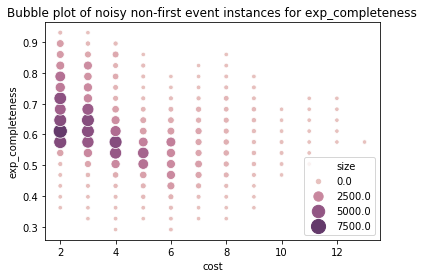

In [95]:
noisy = merged_df['cost'] > 1
not_first = merged_df['case_length'] > 5
scatter_df = merged_df.loc[noisy & not_first, :]

var = 'exp_completeness'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 20)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[['cost', 'binned', 'caseid']].groupby(['cost', 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'size'}, inplace=True)

fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.scatterplot(x='cost', y=var,
               hue='size', size='size',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Bubble plot of noisy non-first event instances')

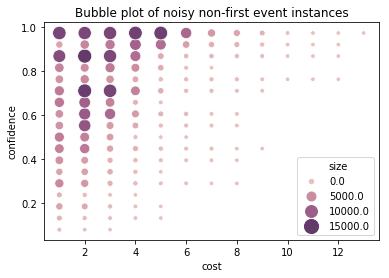

In [15]:
noisy = merged_df['cost'] > 0
not_first = merged_df['case_length'] > 1
scatter_df = merged_df.loc[noisy & not_first, :]

bins = np.linspace(0, 1, 20)
scatter_df['binned'] = pd.cut(scatter_df['confidence'], bins=bins)
grouped = scatter_df[['cost', 'binned', 'caseid']].groupby(['cost', 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df['confidence'] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'size'}, inplace=True)

fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.scatterplot(x='cost', y='confidence',
               hue='size', size='size',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

ax.set_title('Bubble plot of noisy non-first event instances')

In [8]:
stats.spearmanr(noisy_prefix_df['cost'], noisy_hmm_df['avg_final_conformance'])

SpearmanrResult(correlation=0.0018122840674619843, pvalue=0.2147800435130155)

In [9]:
noisy_prefix_df.head()

,caseid,case_length,cost,log
213,73,3,1,log_model_triangular_10_20_30_id_12.pnml_noise...
214,73,4,1,log_model_triangular_10_20_30_id_12.pnml_noise...
215,73,5,1,log_model_triangular_10_20_30_id_12.pnml_noise...
216,73,6,1,log_model_triangular_10_20_30_id_12.pnml_noise...
217,73,7,1,log_model_triangular_10_20_30_id_12.pnml_noise...


In [10]:
noisy_hmm_df.head()

,caseid,case_length,activity,final_conformance,avg_final_conformance,sum_mode_distance,mode_completeness,log
213,73,3,k,0.999649,0.731532,4.25,0.434226,log_model_triangular_10_20_30_id_12.pnml_noise...
214,73,4,b,1.000000,0.798649,4.25,0.502778,log_model_triangular_10_20_30_id_12.pnml_noise...
215,73,5,k,1.000000,0.838919,4.25,0.556097,log_model_triangular_10_20_30_id_12.pnml_noise...
216,73,6,b,1.000000,0.865766,4.25,0.598864,log_model_triangular_10_20_30_id_12.pnml_noise...
217,73,7,l,1.000000,0.884942,4.50,0.614540,log_model_triangular_10_20_30_id_12.pnml_noise...


In [14]:
noisy_prefix_df['cost'].describe()

count    468557.000000
mean          2.648295
std           1.701240
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          13.000000
Name: cost, dtype: float64

In [103]:
stats.spearmanr(filtered_prefix_df['cost'], filtered_hmm_df['avg_final_conformance'])

SpearmanrResult(correlation=-0.35603108095945701, pvalue=0.0)

In [104]:
stats.spearmanr(prefix_df['cost'], hmm_df['avg_final_conformance'])

SpearmanrResult(correlation=-0.32837155860972483, pvalue=0.0)

In [94]:
stats.pearsonr(filtered_prefix_df['cost'], filtered_hmm_df['avg_final_conformance'])

(-0.20211289864827822, 0.0)

In [95]:
stats.pearsonr(prefix_df['cost'], hmm_df['avg_final_conformance'])

(-0.11204720200228008, 0.0)

In [88]:
filtered_patt_df['conformance'].describe()

count    2608635.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: conformance, dtype: float64

In [87]:
filtered_prefix_df['cost'].describe()

count    2.608635e+06
mean     4.549720e-01
std      1.245747e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.300000e+01
Name: cost, dtype: float64

In [89]:
filtered_prefix_df.shape

(2608635, 4)

In [90]:
prefix_df.shape

(2895560, 4)

In [83]:
stats.pearsonr(filtered_prefix_df['cost'], filtered_patt_df['conformance'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(nan, 1.0)

In [16]:
stats.pearsonr(prefix_df['cost'], hmm_df['mode_completeness'])

(-0.36140921378151852, 0.0)

In [12]:
df = pd.merge(prefix_df, hmm_df, on=['log', 'caseid', 'case_length'])

In [42]:
filtered_df = df.loc[df['cost'] > 0, :]
stats.pearsonr(filtered_df['cost'], filtered_df['mode_completeness'])

(-0.19204849372480159, 0.0)

In [25]:
fitting_df = df.loc[df['cost'] == 0, :]

In [38]:
fitting_df['mode_completeness'].describe()

count    2.427003e+06
mean     5.565853e-01
std      1.770120e-01
min      1.458654e-01
25%      4.219646e-01
50%      5.215489e-01
75%      6.614239e-01
max      1.000000e+00
Name: mode_completeness, dtype: float64

In [48]:
false_positive = df.loc[(df['cost'] > 0) & (df['avg_final_conformance'] == 0), :]

In [56]:
df_12 = df.loc[(df['log'].str.contains('_id_12')),:]

In [57]:
df_12_noisy = df_12.loc[(df_12['cost'] > 0), :]

In [64]:
df_12_noisy['cost'].describe()

count    2051.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: cost, dtype: float64

In [60]:
stats.pearsonr(df_12_noisy['cost'], df_12_noisy['mode_completeness'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(nan, 1.0)

In [65]:
df_12.

(82607, 9)

In [55]:
df_8_noisy

,caseid,case_length,cost,log,activity,final_conformance,avg_final_conformance,sum_mode_distance,mode_completeness
2692660,2,2,1,log_model_triangular_10_20_30_id_8.pnml_noise_...,c,0.638295,0.378758,3.75,0.476984
2692661,2,3,1,log_model_triangular_10_20_30_id_8.pnml_noise_...,p,1.000000,0.585838,4.00,0.481250
2692662,2,4,1,log_model_triangular_10_20_30_id_8.pnml_noise_...,k,1.000000,0.689379,4.00,0.544877
2692663,2,5,1,log_model_triangular_10_20_30_id_8.pnml_noise_...,d,1.000000,0.751503,4.00,0.593750
2692785,19,1,1,log_model_triangular_10_20_30_id_8.pnml_noise_...,v,0.250000,0.250000,6.25,0.333333
2692786,19,2,2,log_model_triangular_10_20_30_id_8.pnml_noise_...,j,0.424036,0.337018,9.00,0.223429
2692787,19,3,3,log_model_triangular_10_20_30_id_8.pnml_noise_...,v,1.000000,0.558012,9.00,0.295238
2692788,19,4,3,log_model_triangular_10_20_30_id_8.pnml_noise_...,m,1.000000,0.668509,9.00,0.353064
2692789,19,5,3,log_model_triangular_10_20_30_id_8.pnml_noise_...,j,0.911775,0.717162,9.00,0.401042
2692790,19,6,3,log_model_triangular_10_20_30_id_8.pnml_noise_...,v,1.000000,0.764302,9.00,0.441715
